In [1]:
import pandas as pd
import os
from pathlib import Path
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import numpy as np
import protein_design_utils
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from isambard import ampal

/Users/phr361/anaconda3/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/phr361/anaconda3/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/phr361/anaconda3/lib/python3.11/site-packages/umap/distances.py:1086: NumbaDeprecatio

In [2]:
# Define a function to perform the protein analysis
def analyze_protein(sequence):
    try:
        analysed_seq = ProteinAnalysis(str(sequence))
        molecular_weight = analysed_seq.molecular_weight()
        aromaticity = analysed_seq.aromaticity()
        instability_index = analysed_seq.instability_index()
        flexibility = np.mean(analysed_seq.flexibility())  # flexibility returns a list, so we take the mean
        isoelectric_point = analysed_seq.isoelectric_point()
        return molecular_weight, aromaticity, instability_index, flexibility, isoelectric_point
    
    except Exception as e:
        # In case of any error, return NaN values
        print(f"Error processing sequence: {e}")
        return np.nan, np.nan, np.nan, np.nan, np.nan
    
def keep_top_score(df,value="score"):
# Step 1: Sort the DataFrame
    sorted_df = df.sort_values(by=["pdb_file", value], ascending=[True, False])

    # Step 2: Group by "pdb_file" and "PMPNN weights" and keep the top 2 rows for each pdb_file and top 1 for each PMPNN weights
    # This will require a little more granularity in handling, given the dual requirement
    # First, keep the top 2 scores for each pdb_file
    top_2_per_pdb_file = sorted_df.groupby("pdb_file").head(2)

    # Since we need one per "PMPNN weights" within those top 2, we perform another groupby and take the first entry for each "PMPNN weights"
    final_df = top_2_per_pdb_file.groupby(["pdb_file", "PMPNN weights"]).head(1)

    # Reset index if necessary
    final_df = final_df.reset_index(drop=True)
    return final_df

def pdb_pLDDT(pdb_file_path):
    avg_pLDDT, LDDTs = protein_design_utils.avg_pLDDT(pdb_file_path)
    return avg_pLDDT  # Mock analysis result based on the file path length

def pdb_to_value_df(df,value_name,function,pdb_path_column='RDiff_pdb_file_path'):

    # Step 1: Perform analysis and store results in a dictionary
    analysis_results = {}
    unique_pdb_files = df[pdb_path_column].unique()

    for pdb_path in unique_pdb_files:
        analysis_results[pdb_path] = function(pdb_path)
        print(pdb_path)

    # Step 2: Add new columns to DataFrame for analysis results
    # If your analysis returns multiple values, add more columns as needed
    df[value_name] = np.nan  # Initialize new column with NaN

    # Step 3: Iterate over DataFrame rows and fill in analysis results
    for index, row in df.iterrows():
        pdb_path = row[pdb_path_column]
        if pdb_path in analysis_results:
            
            # Fill in the analysis result for the row
            df.at[index, value_name] = analysis_results[pdb_path]
            
    return df

def plot_dimensionality_reduction(df, color_by=None):
    # Select numerical columns
    numerical_df = df.select_dtypes(include=[np.number])
    
    # Standardize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(numerical_df)
    
    # Dimensionality Reduction
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_features)
    
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(scaled_features)
    
    reducer = umap.UMAP(random_state=42)
    umap_result = reducer.fit_transform(scaled_features)
    
    # Prepare the DataFrame for plotting
    plot_df = pd.DataFrame({
        'PCA1': pca_result[:, 0], 'PCA2': pca_result[:, 1],
        'TSNE1': tsne_result[:, 0], 'TSNE2': tsne_result[:, 1],
        'UMAP1': umap_result[:, 0], 'UMAP2': umap_result[:, 1]
    })
    
    is_color_by_numerical = False
    if color_by and color_by in df.columns:
        plot_df[color_by] = df[color_by].values  # Add the color_by column for coloring
        # Check if the color_by column is numerical
        is_color_by_numerical = pd.api.types.is_numeric_dtype(df[color_by])
    
    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    
    for ax, method in zip(axes, [('PCA1', 'PCA2'), ('TSNE1', 'TSNE2'), ('UMAP1', 'UMAP2')]):
        if is_color_by_numerical:
            # Use a continuous color bar for numerical data
            points = ax.scatter(plot_df[method[0]], plot_df[method[1]], c=plot_df[color_by], cmap='viridis')
            fig.colorbar(points, ax=ax, label=color_by)
        else:
            # Use discrete colors for categorical data
            sns.scatterplot(ax=ax, x=method[0], y=method[1], hue=color_by, data=plot_df, palette='viridis', legend="full")
        
        ax.set_title(method[0].split('1')[0])
    
    plt.tight_layout()
    plt.show()
    

def reduce_memory_usage(df):
    """
    Reduce memory usage of a pandas DataFrame by converting data types.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame to reduce memory usage.
    
    Returns:
    pandas.DataFrame: DataFrame with reduced memory usage.
    """
    # Memory usage before reduction
    memory_before = df.memory_usage().sum() / (1024**2) # in MB
    
    # Iterate over each column
    for col in df.columns:
        col_type = df[col].dtype
        
        # Convert numeric columns to more memory-efficient types
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        # Convert object columns to category if unique values are less than 50% of total rows
        else:
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')
    
    # Memory usage after reduction
    memory_after = df.memory_usage().sum() / (1024**2) # in MB
    
    print("Memory usage before reduction: {:.2f} MB".format(memory_before))
    print("Memory usage after reduction: {:.2f} MB".format(memory_after))
    
    return df


### RF Diff job submitted 24JUL24 for all combinations of Beta and Normal weights.

In [3]:
df1 = pd.read_excel('att1.xlsx')
df2 = pd.read_excel('att2.xlsx')

In [4]:
df = pd.concat([df1,df2],ignore_index=True)

In [8]:
df = df.iloc[:,3:]

In [9]:
df = df.reset_index(drop=True)
df = df.reset_index(drop=False)

In [10]:
df

,index,pdb_file,sequence,score,global_score,seq_recovery,fasta_file_path,PMPNN weights,sequence_length,RDiff_pdb_file_path,...,flexibility,isoelectric_point,avg_pLDDT,RF_weights,fasta_path,ESM_pdb_path,RFDiff_binder_pdb_path,ESMFold_pLDDT,RFDiff_ESM_TM_score,attempt
0,0,_48,EYGRLRRQMIEELTAAIANLSTAISNLNTALALANQLAAVDPALAT...,1.1170,1.3323,0.0185,RF_diff/round1/normal_weights/PMPNN/normal_wei...,normal,162,RF_diff/round1/normal_weights/_48.pdb,...,1.003906,4.847656,0.541016,Normal,./att1/RF_normal/all_fastas/normal_48.fasta,./att1/RF_normal/ESM_outputs/normal_48_result/...,./att1/RF_normal/RFDiff_files/binders_only/_48...,91.305825,0.9757,1
1,1,_25,DAATKVAKEAREKCEEALKLDPLEGVRRCTEAFAALTAAVGTPETA...,0.9239,1.2625,0.0247,RF_diff/round1/normal_weights/PMPNN/normal_wei...,normal,162,RF_diff/round1/normal_weights/_25.pdb,...,1.001953,5.011719,0.541016,Normal,./att1/RF_normal/all_fastas/normal_25.fasta,./att1/RF_normal/ESM_outputs/normal_25_result/...,./att1/RF_normal/RFDiff_files/binders_only/_25...,91.135659,0.9882,1
2,2,_18,AEAEALLKGAEKAAKALEEAAKAAIAALKAGDIAAATKHMSDACLA...,0.9458,1.2586,0.0427,RF_diff/round1/normal_weights/PMPNN/normal_wei...,normal,164,RF_diff/round1/normal_weights/_18.pdb,...,1.010742,5.371094,0.538086,Normal,./att1/RF_normal/all_fastas/normal_18.fasta,./att1/RF_normal/ESM_outputs/normal_18_result/...,./att1/RF_normal/RFDiff_files/binders_only/_18...,90.836174,0.9783,1
3,3,_25,SMATEVAKEAARECEAALEGDPLEGVRRCLRALARLTEAVGSPETA...,0.8889,1.2312,0.0370,RF_diff/round1/normal_weights/PMPNN/soluble_we...,soluble,162,RF_diff/round1/normal_weights/_25.pdb,...,0.997070,4.929688,0.541016,Normal,./att1/RF_normal/all_fastas/soluble_25.fasta,./att1/RF_normal/ESM_outputs/soluble_25_result...,./att1/RF_normal/RFDiff_files/binders_only/_25...,90.815451,0.9875,1
4,4,_2,AKEQLKANAKETEELLNKANDALIDLARRVAEADGLVGSHLYLFAL...,0.9623,1.2471,0.0452,RF_diff/round1/normal_weights/PMPNN/soluble_we...,soluble,177,RF_diff/round1/normal_weights/_2.pdb,...,0.998535,4.890625,0.519043,Normal,./att1/RF_normal/all_fastas/soluble_2.fasta,./att1/RF_normal/ESM_outputs/soluble_2_result/...,./att1/RF_normal/RFDiff_files/binders_only/_2_...,90.409836,0.9850,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,65,_6,MREECEREAEELTKKAEKKAKVPVNKNAIERTLKLAFALMEVVARA...,0.9081,1.1818,0.0657,RF_diff/round2/normal_weights/PMPNN/soluble_we...,soluble,198,RF_diff/round2/normal_weights/_6.pdb,...,1.002930,4.824219,0.544922,Normal,./att2/RF_normal/all_fastas/soluble_6.fasta,./att2/RF_normal/ESM_outputs/soluble_6_result/...,./att2/RF_normal/RFDiff_files/binders_only/_6_...,81.573228,0.9424,2
66,66,_2,MEAEQERLAEEAVRLAREFCKVPVNKEVEERYAAAVRAAARAIGEV...,0.9735,1.2225,0.0303,RF_diff/round2/normal_weights/PMPNN/soluble_we...,soluble,198,RF_diff/round2/normal_weights/_2.pdb,...,1.000977,4.800781,0.544922,Normal,./att2/RF_normal/all_fastas/soluble_2.fasta,./att2/RF_normal/ESM_outputs/soluble_2_result/...,./att2/RF_normal/RFDiff_files/binders_only/_2_...,81.145306,0.9515,2
67,67,_4,SDELRRFGREAVERALELALATPLDPEGQARVEEEARRALALLEAA...,1.0093,1.2458,0.0657,RF_diff/round2/normal_weights/PMPNN/soluble_we...,soluble,198,RF_diff/round2/normal_weights/_4.pdb,...,1.003906,4.683594,0.544922,Normal,./att2/RF_normal/all_fastas/soluble_4.fasta,./att2/RF_normal/ESM_outputs/soluble_4_result/...,./att2/RF_normal/RFDiff_files/binders_only/_4_...,81.142076,0.9604,2
68,68,_10,MEELLRRLTEESERCRELSLAEPLNKDVLEEAKELEEKVIEKAEEE...,0.9462,1.2189,0.0404,RF_diff/round2/normal_weights/PMPNN/soluble_we...,soluble,198,RF_diff/round2/normal_weights/_10.pdb,...,1.012695,4.648438,0.544922,Normal,./att2/RF_normal/all_fastas/soluble_10.fasta,./att2/RF_normal/ESM_outputs/soluble_10_result...,./att2/RF_normal/RFDiff_files/binders_only/_10...,80.944582,0.9606,2


In [12]:
target_seq = 'LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALAVLSNYDANKTGLKELPMRNLQEILHGAVRFSNNPALCNVESIQWRDIVSSDFLSNMSMDFQNHLGSCQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGCTGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYVVTDHGSCVRACGADSYEMEEDGVRKCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAFENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKLFGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSCRNVSRGRECVDKCNLLEGEPREFVENSECIQCHPECLPQAMNITCTGRGPDNCIQCAHYIDGPHCVKTCPAGVMGENNTLVWKYADAGHVCHLCHPNCTYGCTGPGLEGCPTNGPKIPS'



In [13]:
target_seq[300:500]

'KCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAFENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKLFGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCV'

In [14]:
def write_fasta_files_AFpulldown(df):
    
    # Iterate over rows of the dataframe
    for index, row in df.iterrows():
        # Generate the filename for the FASTA file using the pdb_file column
        file_name = f"AF_pulldown.fasta"
        file_name_txt = f"AF_pulldown.txt"
        
        # Write the sequence to the FASTA file
        with open(file_name, "a") as fasta_file:
            fasta_file.write(f">{index}\n")
            fasta_file.write(f"{row['sequence']}\n")
            
        # Write the sequence to the FASTA file
        with open(file_name_txt, "a") as fasta_file:
            fasta_file.write(f"{index}\n")
            
write_fasta_files_AFpulldown(df)


# Go run AF pulldown

In [15]:
df_AFpulldown_results = pd.read_csv('./AlphaPulldown/predictions_with_good_interpae.csv')


In [16]:
df_AFpulldown_results

,jobs,interface,Num_intf_residues,Polar,Hydrophobhic,Charged,contact_pairs,sc,hb,sb,int_solv_en,int_area,pi_score,iptm_ptm,iptm,mpDockQ/pDockQ
0,SngA_trim_and_42,C_B,34,0.235,0.382,0.176,30,0.512,10,14,-9.40,1470.66,1.01,0.918544,0.915746,0.623748
1,SngA_trim_and_4,C_B,15,0.133,0.467,0.133,15,0.631,7,1,-9.10,917.23,1.65,0.904135,0.899362,0.553564
2,SngA_trim_and_24,C_B,30,0.233,0.333,0.233,27,0.561,7,7,-11.49,1223.57,1.07,0.901485,0.896979,0.620491
3,SngA_trim_and_22,C_B,26,0.269,0.385,0.115,24,0.564,7,1,-16.15,1262.61,1.52,0.897158,0.891763,0.605929
4,SngA_trim_and_44,C_B,21,0.333,0.333,0.048,16,0.486,10,11,-5.46,1189.73,0.22,0.889514,0.883082,0.560945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,SngA_trim_and_1,C_B,31,0.355,0.484,0.065,34,0.233,5,0,-8.83,885.80,-1.48,0.340663,0.267614,0.100989
57,SngA_trim_and_60,C_B,29,0.310,0.241,0.172,29,0.314,5,1,-8.26,1038.88,-1.32,0.326543,0.260994,0.152414
58,SngA_trim_and_58,C_B,16,0.313,0.250,0.063,12,0.327,2,4,-2.54,713.34,-1.79,0.310254,0.240437,0.059644
59,SngA_trim_and_40,C_B,29,0.207,0.414,0.138,24,0.313,6,1,-5.26,1084.23,-2.12,0.302797,0.232319,0.149883


<Figure size 640x480 with 0 Axes>

<Figure size 6000x6000 with 0 Axes>

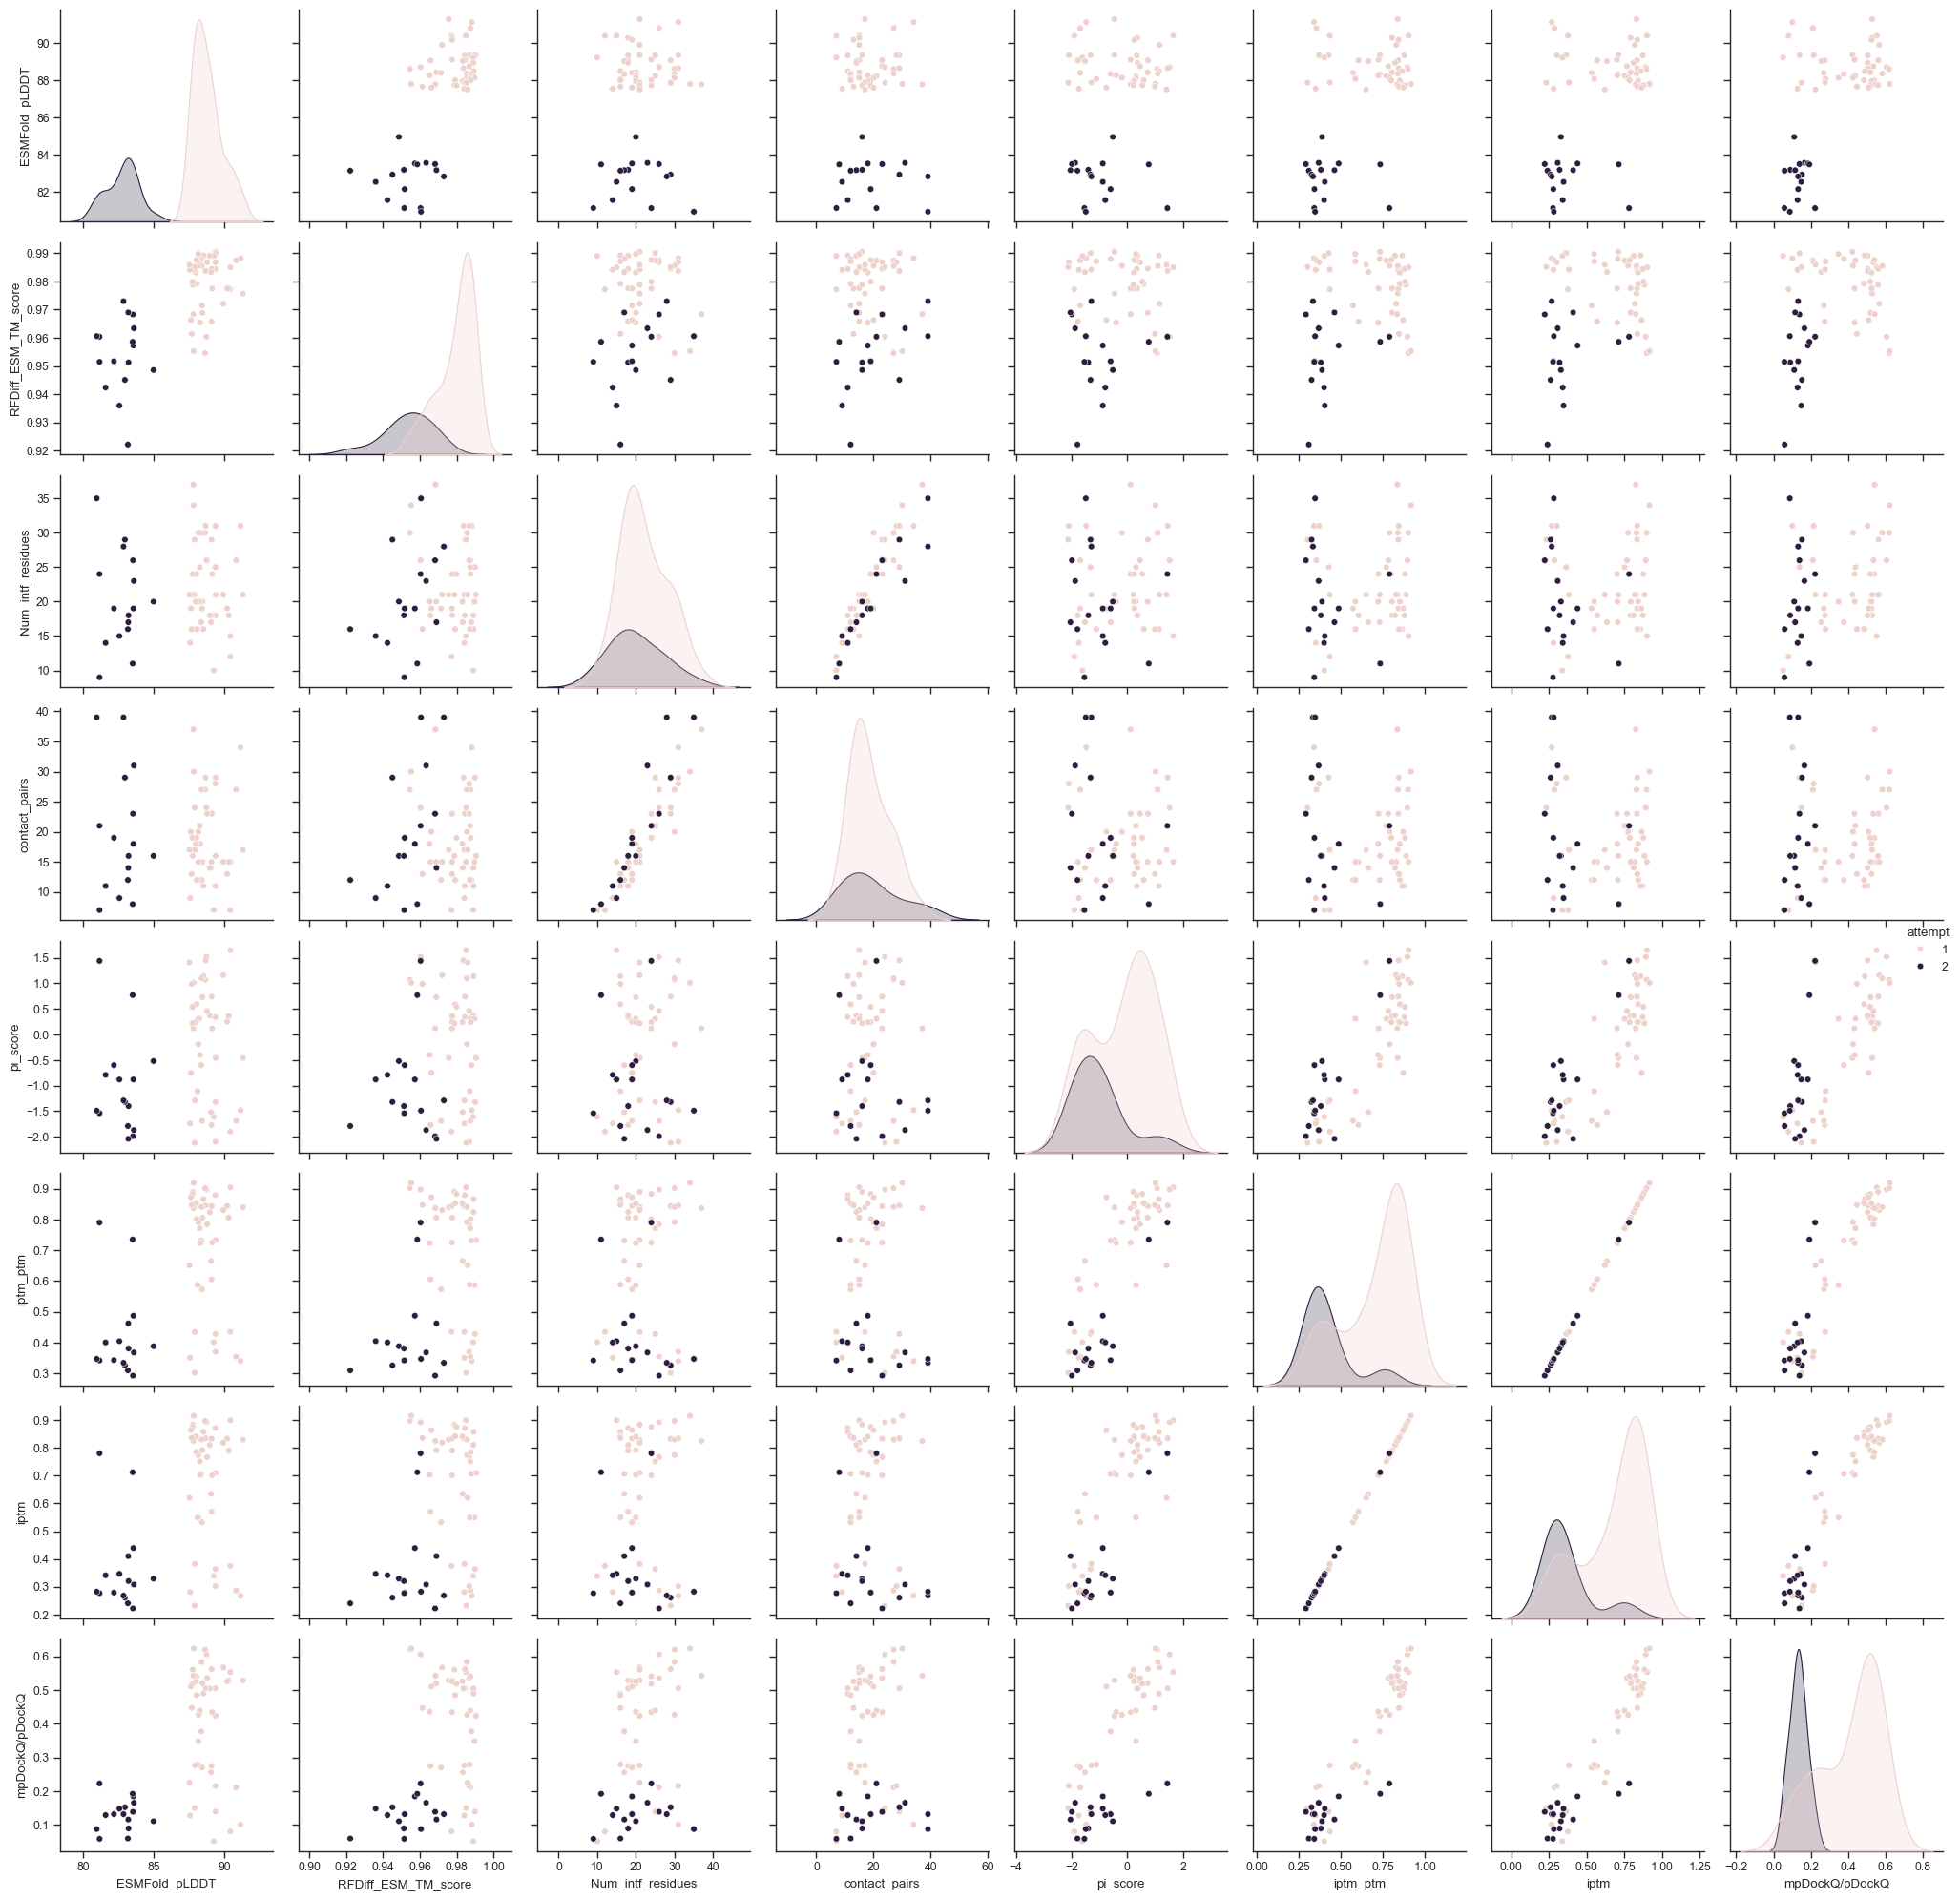

In [17]:
df_AFpulldown_results['jobs_index'] = df_AFpulldown_results['jobs'].str.extract('(\d+)').astype(int)
df_AFpulldown_results=df_AFpulldown_results.sort_values('jobs_index')
df_AFpulldown_results=df_AFpulldown_results.set_index('jobs_index')
df_results=df.merge(df_AFpulldown_results,left_index=True,right_index=True)
df_results=df_results[['index', 'jobs',
      'ESMFold_pLDDT', 'RFDiff_ESM_TM_score', 
       'Num_intf_residues', 'Polar', 'Hydrophobhic', 'Charged',
       'contact_pairs', ' sc', ' hb', ' sb', ' int_solv_en', ' int_area',
       'pi_score', 'iptm_ptm', 'iptm', 'mpDockQ/pDockQ',
                    
        'pdb_file', 'sequence', 'sequence_length',

       'RDiff_pdb_file_path', 'molecular_weight', 'aromaticity',
       'instability_index', 'flexibility', 'isoelectric_point',
      
        'PMPNN weights', 'score', 'global_score',   'seq_recovery',
         'RF_weights', 'attempt',
        'fasta_path', 'fasta_file_path','ESM_pdb_path', 'RFDiff_binder_pdb_path',]]

plot_df = df_results[[
      'ESMFold_pLDDT', 'RFDiff_ESM_TM_score', 
       'Num_intf_residues', 
       'contact_pairs','attempt',
       'pi_score', 'iptm_ptm', 'iptm', 'mpDockQ/pDockQ',
        'PMPNN weights', 
       ]]
plt.clf()
sns.set_context('paper')
sns.set_style('ticks')
fig = plt.figure(0,(10,10),dpi=600) 
sns.pairplot(plot_df, hue="attempt",)

#plt.xticks(size=25)
#plt.yticks(size=25)

plt.tight_layout()
plt.savefig('all_v_all_AFpulldown_PMPNN_weights.png',transparent=True)
plt.show()

In [18]:
df_results.columns

Index(['index', 'jobs', 'ESMFold_pLDDT', 'RFDiff_ESM_TM_score',
       'Num_intf_residues', 'Polar', 'Hydrophobhic', 'Charged',
       'contact_pairs', ' sc', ' hb', ' sb', ' int_solv_en', ' int_area',
       'pi_score', 'iptm_ptm', 'iptm', 'mpDockQ/pDockQ', 'pdb_file',
       'sequence', 'sequence_length', 'RDiff_pdb_file_path',
       'molecular_weight', 'aromaticity', 'instability_index', 'flexibility',
       'isoelectric_point', 'PMPNN weights', 'score', 'global_score',
       'seq_recovery', 'RF_weights', 'attempt', 'fasta_path',
       'fasta_file_path', 'ESM_pdb_path', 'RFDiff_binder_pdb_path'],
      dtype='object')

################
###Saving data and plot###
################


<Figure size 640x480 with 0 Axes>

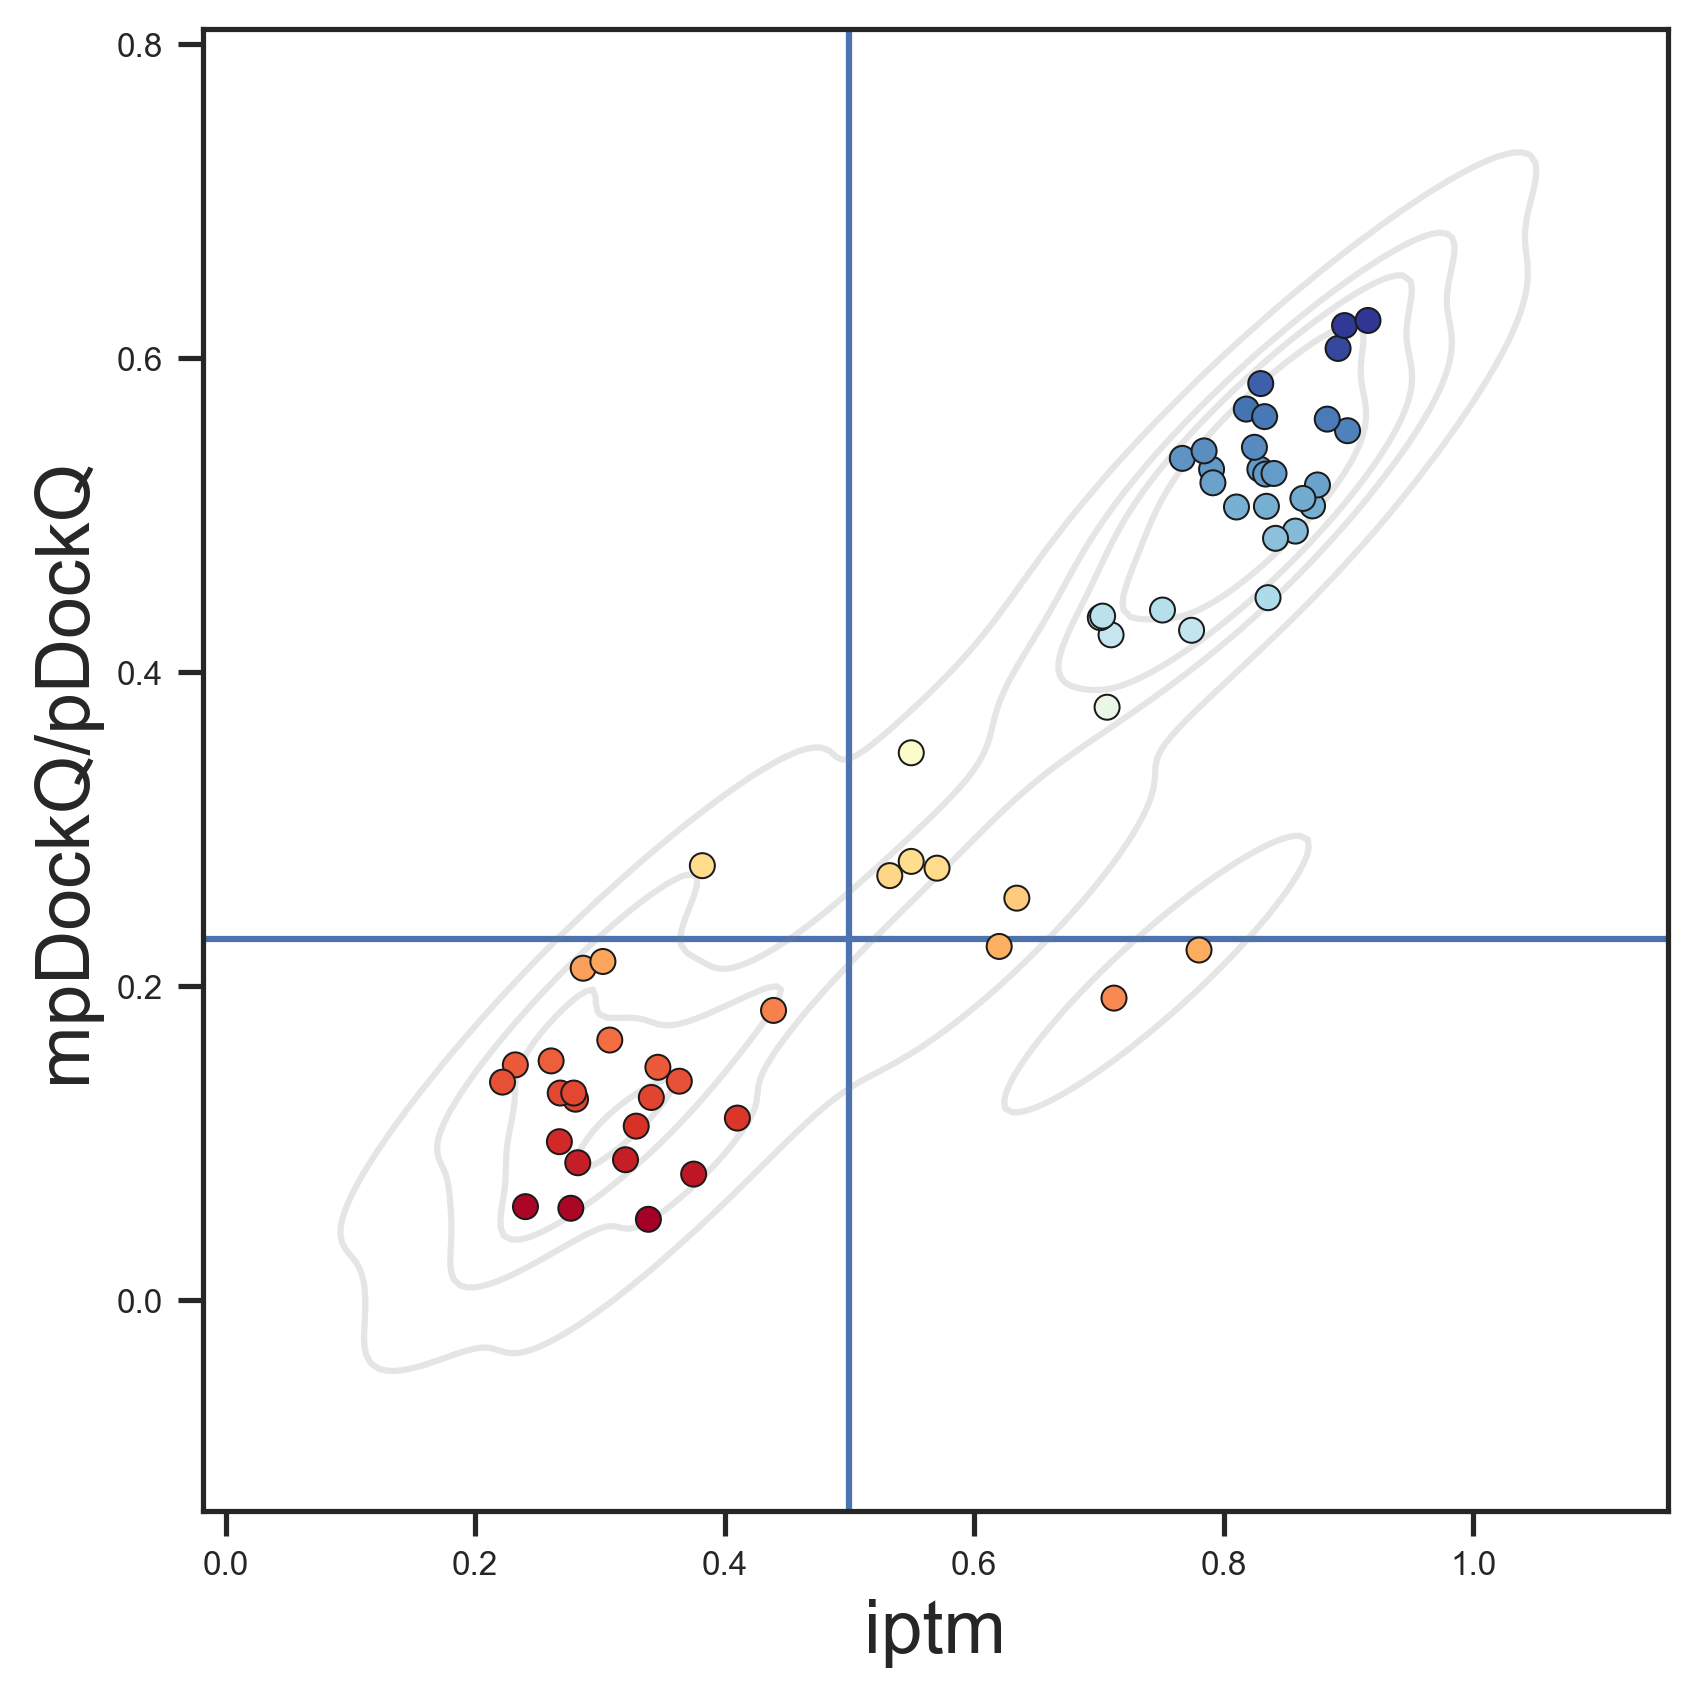

In [19]:
df=df_results.copy()

cut_TM = 0.5 #0.26
cut_pLDDT = 0.23

TM_col_name = 'iptm'
pLDDT_col_name = 'mpDockQ/pDockQ'
df_TM = df[df[TM_col_name]>cut_TM]
df_pLDDT = df_TM[df_TM[pLDDT_col_name]>cut_pLDDT]
df_best = df_pLDDT[df_pLDDT[TM_col_name]>cut_TM]

fnt= 8
plt.clf()
sns.set_context('paper')
sns.set(font_scale=1.5)
sns.set_style('ticks')
plt.figure(0,(6,6),dpi=300)
hu=pLDDT_col_name

plt.axhline(y=cut_pLDDT,zorder=-2)
plt.axvline(x=cut_TM,zorder=-2)

sns.scatterplot(data=df,x=TM_col_name,y=pLDDT_col_name,hue=hu,palette='RdYlBu',edgecolor='k',zorder=1)
#sns.scatterplot(data=df_best,x=TM_col_name,y=pLDDT_col_name

sns.kdeplot(data=df,x=TM_col_name,y=pLDDT_col_name,color='grey',bw_adjust=0.65,levels=5,alpha=0.2,zorder=-1)
#sns.scatterplot(data=df,x='TM-scores',y='pLDDT',sizes='Length')
#sns.lmplot(data=df,x='TM-scores',y='pLDDT',ci='sd')
plt.legend('',frameon=False)
#plt.legend(title=hu,loc=(1.1,0.1))

plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)
#plt.ylabel('2BC/(BB+CC) (REU)',fontsize=12)
#plt.xlabel('Generation',fontsize=12)
plt.tight_layout()
print('################\n###Saving data and plot###\n################')
#plt.savefig('output.svg',transparent=True,dpi=2000)


In [20]:
df_results.columns

Index(['index', 'jobs', 'ESMFold_pLDDT', 'RFDiff_ESM_TM_score',
       'Num_intf_residues', 'Polar', 'Hydrophobhic', 'Charged',
       'contact_pairs', ' sc', ' hb', ' sb', ' int_solv_en', ' int_area',
       'pi_score', 'iptm_ptm', 'iptm', 'mpDockQ/pDockQ', 'pdb_file',
       'sequence', 'sequence_length', 'RDiff_pdb_file_path',
       'molecular_weight', 'aromaticity', 'instability_index', 'flexibility',
       'isoelectric_point', 'PMPNN weights', 'score', 'global_score',
       'seq_recovery', 'RF_weights', 'attempt', 'fasta_path',
       'fasta_file_path', 'ESM_pdb_path', 'RFDiff_binder_pdb_path'],
      dtype='object')

In [21]:
!pwd

/Users/phr361/Documents/Coding/ProteinDesign/AntiAntiDefence/ProteinDesignCompAug


/Users/phr361/anaconda3/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [22]:
df_to_order=df_results.copy()


In [23]:
df_to_order= df_to_order[df_to_order['mpDockQ/pDockQ']>0.23]
df_to_order= df_to_order[df_to_order['iptm']>0.5]

In [24]:
df_to_order['sequence']

0     EYGRLRRQMIEELTAAIANLSTAISNLNTALALANQLAAVDPALAT...
4     AKEQLKANAKETEELLNKANDALIDLARRVAEADGLVGSHLYLFAL...
6     AAAARAAHIAARAATAAAAAAMAAKAAEAYKKLAKEVAKDPKAKAL...
8     SALAAARAVMDATADRIAAIIARCTADPATLAAVGEALRAAGAAMA...
9     AALAAARAAMAAGAERIAAIVAEATADPEALAALGAALIAAGAAMS...
11    KEKKLANLEIALESVEEAEKYIEEARKKAKDPEEVQRYLAEAAGHF...
14    MVSLGLGVAVAGADGDDVIESLRLLGAMAADLAKMAKGRGMAVSVG...
16    MEEIAAAAEALAEAAAEAAKVGPLAQEAVLAAGNALMIAAGIAPEV...
17    AAAAAEAARRREEQIERAREATGEAEAFGLEVVARCTAAGALGQLD...
18    SAERAAAVAAAADRIAAAAAGFAAAAERAFNAVAAGSPEVAELARA...
19    EEAKKLLKEAAAKAEEAKAAAKALGALAQQLAPVLSGGAVSAILEM...
20    MMEAVRAAAERLKAAAASLATGCAFFANGVLKGSSGACCMGALSFG...
21    DEEERQKHNEARAKACRAFAEMERRIAAALAALAAQAAADPKAKAL...
22    MEDIEEAGVAMARAAIVAGKVSPLAQEIVLDAGNGLCIVAGAAPEV...
23    SLEETVLREAEELVRALREFGDVAVRTLRALMANPADREAALLVAE...
24    AALEAEKAAKKKEQLEKEKEATDEAQAKGLEAQALATEAGALGGHD...
26    ASPEEIRRAAEEVIRRLRELDRRAAAVLEAARTGSAAETAEEAARL...
27    AAAEEEERRKRQKELVEKIRALATAAADALTEAAALAEKAAE

In [27]:
df_results.to_excel('results.xlsx')

In [25]:
def add_Met(sequence):
    if sequence.startswith('M'):
        return sequence
    else:
        return 'M' + sequence

# Apply the function to the 'sequence' column
df_to_order['sequence'] = df_to_order['sequence'].apply(add_Met)

In [ ]:
df

In [ ]:
df_to_order.to_excel('df_to_order.xlsx')

In [ ]:
df_to_genscript = df_to_order[['index','sequence', 'sequence_length', 
       'molecular_weight', 'aromaticity', 'instability_index', 'flexibility',
       'isoelectric_point']]

In [ ]:
df_to_genscript.rename(columns={"index": "Design Number / Name"})
df_to_genscript.to_excel('genscript_sheet.xlsx')